# BRIEF描述子生成算法

## 一：介绍

我们知道SIFT算法通常通过对每个关键点生成128个特征向量作为描述子、SURF算法通常对关键点生成最少64个特征向量作为描述子。但是对于图像来说创建上千或者上万个这样的描述子内存开销比较大，运行速度受到严重影响。特别对嵌入式设备与一定设备来说，内存限制尤为明显，而且匹配的时候计算也比较耗时。

 

但是实际上这些特征数据OpenCV在匹配的时候并没有完全利用上，而是通过PCA、LDA等方法对它进行压缩，或者是LSH(局部敏感哈希)方法把这些特征描述子压缩从浮点数转换为二进制字符串，然后通过汉明距离(HammingDistance)进行比较。这样就可以通过简单的异或操作（OXR）与位值计算来加速实现对象特征匹配，对于SSE指令集的CPU这种方法可以大大加速。但是这种方法仍然需要首先计算描述子，然后使用LSH方法进行压缩，无法避免过度的内存开销。

 

而Brief方法可以直接通过关键点生成二进制字符串，跳过了中间描述子生成步骤，这样就大大减低了内存要求与计算开销。Brief方法主要思路是对每个关键点附件选择若干个像素点，将这些像素点的像素值组合成二进制字符串，然后使用该字符串作为该关键点的描述子。

此方法是在2010年提出来的。结果实验测试在选取256个点甚至128个点情况下对没有旋转对象识别率非常高而且速度比SURF还快。但是当对象有旋转时候由于Brief不能很好的支持旋转不变性识别，特别是当旋转角度超过30度以上，准确率会快速下降。

## 二：Brief描述子生成步骤

Brief描述子生成首先需要产生足够多的随机点对，然后根据随机点对坐标得到对应像素值，对所有点对进行二进制字符串拼接，拼接完成即生成了描述子。

第一步：选择关键点周围SxS大小正方形图像区块，进行高斯模糊。这样做的原因是需要降低图像随机噪声，OpenCV在完成Brief的时候考虑到效率问题并没有采用高斯模糊而是采用了基于积分图的盒子模糊方法。

第二步：选择n个像素点对，其中n的取值常见为256、此外还可以是128、512。每个点对比较像素值输出如下。

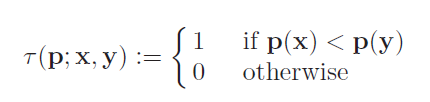

对N个点对完成操作最终得到了二进制字符串，表达如下：

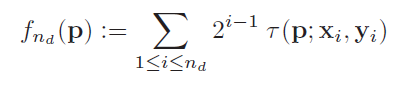

## 三：方法

高斯模糊比较

通过实验对比高斯sigma参数在0~3之间准确率比较高，窗口大小取值在9x9取得比较好的模糊去噪效果。论文中实验结果图示如下：

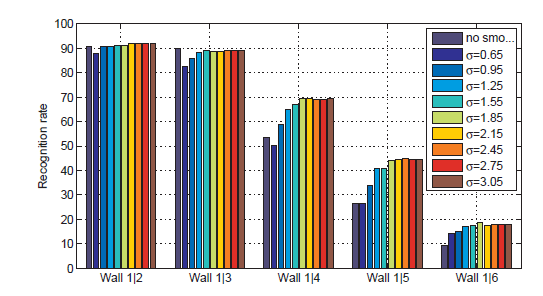

随机点生成方法比较

对于随机生成点对的方法，论文中给出了五种随机方法与实验结果比较，五种方法描述如下：

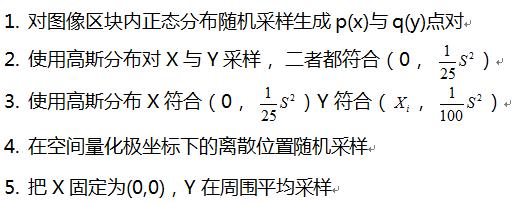

图示如下：

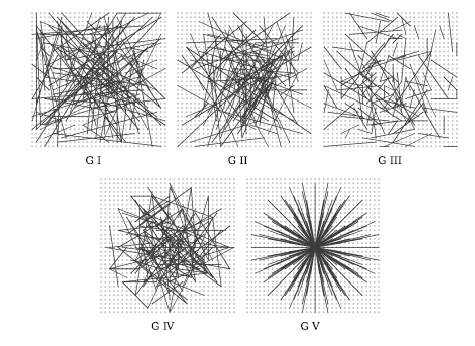

对图像五个几何采样完成测试结果如下：

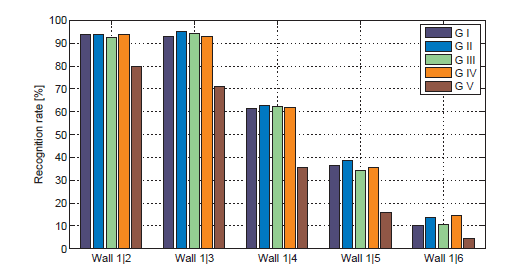

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import cv2.xfeatures2d as features2d
import numpy as np
import skimage
import skimage.io
import imageio

In [5]:
src = imageio.imread('../datas/f3.jpg')
model = imageio.imread('../datas/f3-model.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
model_gray = cv2.cvtColor(model,cv2.COLOR_RGB2GRAY)

In [6]:
detector = cv2.FastFeatureDetector.create()
keypoints_obj = detector.detect(gray)
keypoints_scene = detector.detect(model_gray)

In [28]:
descriptor = features2d.BriefDescriptorExtractor_create()
objkeypoints,descriptor_obj = descriptor.compute(gray,keypoints_obj)
scenekeypoints,descriptor_scene = descriptor.compute(model_gray,keypoints_scene)

In [29]:
matcher = cv2.BFMatcher_create()
matches = matcher.match(descriptor_obj,descriptor_scene)

In [34]:
dst = cv2.drawMatches(src,keypoints_obj,model,keypoints_scene,matches,None)

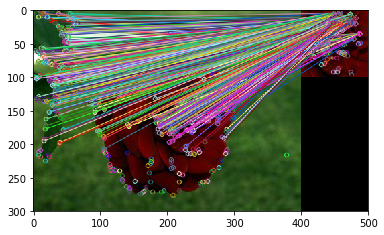

In [35]:
plt.imshow(dst)

参考：

[1]. https://blog.csdn.net/jia20003/article/details/54850531